In [22]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, make_scorer
)


# Import the matplotlib.pyplot module as plt for plotting graphs and visualizations
import matplotlib.pyplot as plt

# Import the seaborn library as sns for statistical data visualization
import seaborn as sns



In [ ]:
# Read the Ccleaned student dataset without grades
student_without_grades=pd.read_csv('student_without_grades_encoded.csv',sep=None, engine="python")

df3 = student_without_grades.copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 72 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                382 non-null    int64  
 1   Medu                               382 non-null    int64  
 2   Fedu                               382 non-null    int64  
 3   traveltime_x                       382 non-null    int64  
 4   studytime_x                        382 non-null    int64  
 5   failures_x                         382 non-null    int64  
 6   famrel_x                           382 non-null    int64  
 7   freetime_x                         382 non-null    int64  
 8   goout_x                            382 non-null    int64  
 9   Dalc_x                             382 non-null    int64  
 10  Walc_x                             382 non-null    int64  
 11  health_x                           382 non-null    int64  

In [36]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, make_scorer
)

#Read the Ccleaned student dataset without grades
student_without_grades=pd.read_csv('student_without_grades_encoded.csv',sep=None, engine="python")

df3 = student_without_grades.copy() 

exclude = {"at_risk_total_At Risk (Math Only)", "at_risk_total_Not At Risk", "at_risk_total_At Risk (Port Only)","G3_x","G3_y","at_risk_math","at_risk_port"} 

# Select all columns except the excluded ones 
use_cols = [c for c in df3.columns if c not in exclude] 
X = df3[use_cols].copy() 
# y = both targets 

y = df3[["G3_x", "G3_y"]].astype(float).values 


# ==== 2. Train/test split ==== 

X_tr, X_te, y_tr, y_te = train_test_split( X, y, test_size=0.2, random_state=42 ) 

# ==== 3. Define model ==== 

rf = RandomForestRegressor( 
    n_estimators=300, 
    max_depth=10, 
    max_features=None, 
    min_samples_leaf=2, 
    min_samples_split=2, 
    random_state=42, 
    n_jobs=-1 ) 


In [37]:
# ==== 5. Fit on train + evaluate on test ====
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_te)

mae_raw  = np.array([
    mean_absolute_error(y_te[:, 0], y_pred[:, 0]),
    mean_absolute_error(y_te[:, 1], y_pred[:, 1]),
])
rmse_raw = np.array([
    np.sqrt(mean_squared_error(y_te[:, 0], y_pred[:, 0])),
    np.sqrt(mean_squared_error(y_te[:, 1], y_pred[:, 1])),
])
r2_raw   = np.array([
    r2_score(y_te[:, 0], y_pred[:, 0]),
    r2_score(y_te[:, 1], y_pred[:, 1]),
])

print(f"\nTest (strong only) — G3_x: MAE {mae_raw[0]:.2f} | RMSE {rmse_raw[0]:.2f} | R2 {r2_raw[0]:.2f}")
print(f"Test (strong only) — G3_y: MAE {mae_raw[1]:.2f} | RMSE {rmse_raw[1]:.2f} | R2 {r2_raw[1]:.2f}")

print(
    "Test (avg, strong only):  "
    f"MAE {mean_absolute_error(y_te, y_pred):.2f} | "
    f"RMSE {np.sqrt(mean_squared_error(y_te, y_pred)):.2f} | "
    f"R2 {r2_score(y_te, y_pred):.2f}"
)



Test (strong only) — G3_x: MAE 2.89 | RMSE 3.95 | R2 0.30
Test (strong only) — G3_y: MAE 1.77 | RMSE 2.71 | R2 0.22
Test (avg, strong only):  MAE 2.33 | RMSE 3.39 | R2 0.26


# Model results 

* **MAE/RMSE:** On average we’re off by ~**3 pts** in Math and ~**1.8 pts** in Portuguese. 

## Project insights

* **Useful for early risk flagging:** With ~2–3 point error, the model can help triage students who are near the pass/fail boundary but shouldn’t be the only decision signal.

* Bottom line: the model is **directionally helpful** (especially for early alerts) but **not yet decision-grade**. Improving features + tuned ensembles should lift R² and push MAE/RMSE down.


# **Plots to understand the model performance**

Top 15 features:
 failures_x         0.196655
absences_x         0.148041
absences_y         0.037355
total_absences     0.036868
age                0.029821
health_x           0.026118
mean_parent_edu    0.025182
Medu               0.022647
goout_y            0.021733
freetime_x         0.021723
health_y           0.021004
Walc_x             0.020798
freetime_y         0.018427
sex_M              0.016445
traveltime_y       0.016391
dtype: float64


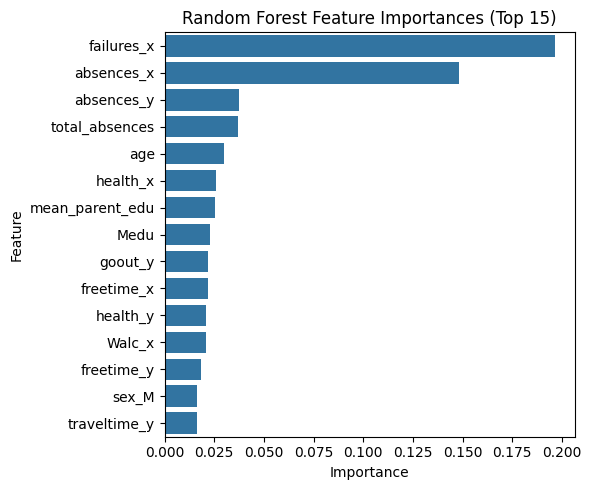

In [38]:
# Feature importance 
# RandomForestRegressor returns one set of importances averaged over outputs.
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 15 features:\n", fi.head(15))
plt.figure(figsize=(6,5))
sns.barplot(x=fi.values[:15], y=fi.index[:15], orient='h')
plt.title("Random Forest Feature Importances (Top 15)")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()


### **Key Insights from Feature Importance**

The Random Forest model reveals that **academic engagement factors** are the strongest predictors of student performance.
Variables like **previous failures (`failures_x`)** and **absences in both subjects (`absences_x`, `absences_y`, `total_absences`)** dominate the model’s decisions, showing that consistent attendance and avoiding past course repetition are critical for success.

Moderate predictors such as **age**, **health**, and **parent education level** also contribute, but far less. Social or demographic factors (e.g., **gender, free time, going out**) have only small influence.

For our project, this means that **interventions targeting attendance, homework completion, and early academic support** will likely have the biggest impact on improving student outcomes—much more than focusing on demographics or lifestyle differences.


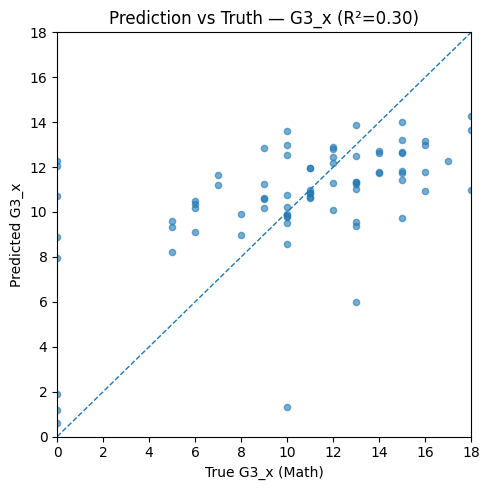

In [29]:
idx = 0  # G3_x column
plt.figure(figsize=(5, 5))
plt.scatter(y_te[:, idx], y_pred[:, idx], alpha=0.6, s=20)

lims = [min(y_te[:, idx].min(), y_pred[:, idx].min()),
        max(y_te[:, idx].max(), y_pred[:, idx].max())]
plt.plot(lims, lims, '--', linewidth=1)
plt.xlim(lims); plt.ylim(lims)

plt.xlabel("True G3_x (Math)")
plt.ylabel("Predicted G3_x")
plt.title(f"Prediction vs Truth — G3_x (R²={r2_score(y_te[:, idx], y_pred[:, idx]):.2f})")

plt.tight_layout()
plt.show()


### Prediction vs Truth — G3_x (Math)
- **Result:** The model captures some trends but has limited accuracy; predictions are only moderately correlated with true scores.

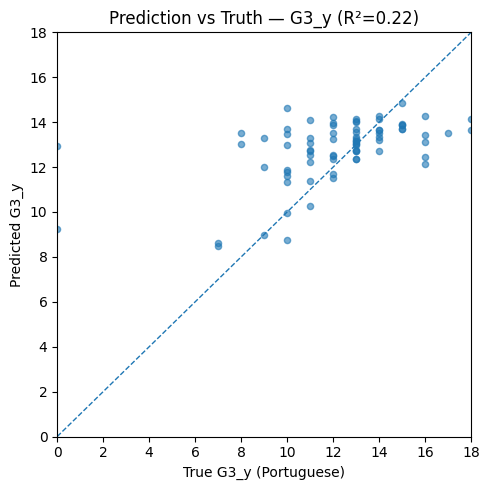

In [31]:
idx = 1  # G3_y column
plt.figure(figsize=(5, 5))
plt.scatter(y_te[:, idx], y_pred[:, idx], alpha=0.6, s=20)

lims = [min(y_te[:, idx].min(), y_pred[:, idx].min()),
        max(y_te[:, idx].max(), y_pred[:, idx].max())]
plt.plot(lims, lims, '--', linewidth=1)
plt.xlim(lims); plt.ylim(lims)

plt.xlabel("True G3_y (Portuguese)")
plt.ylabel("Predicted G3_y")
plt.title(f"Prediction vs Truth — G3_y (R²={r2_score(y_te[:, idx], y_pred[:, idx]):.2f})")

plt.tight_layout()
plt.show()


### Prediction vs Truth — G3_y (Portuguese)

- **Result:** Weak correlation between predictions and true scores; the model struggles to capture patterns in Portuguese performance compared to math.